<a href="https://colab.research.google.com/github/Arturus/conv_simulator/blob/master/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Import code
!git clone https://github.com/Arturus/conv_simulator.git
!cp -r conv_simulator/consim .

Cloning into 'conv_simulator'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 35 (delta 12), reused 24 (delta 8), pack-reused 0
Unpacking objects: 100% (35/35), done.


In [0]:
#@title Import libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.colors as colors
import numpy as np
from scipy import stats
from scipy.stats import beta

from consim.strategy import NaiveStrategy, HalvingStrategy, SoftmaxStrategy, EpsilonDecreasingStrategy, CBRacingStrategy
from consim.prob_matching import ProbMatchingStrategy
from consim.cr_distr import LogNormalConversion, ConstantConversion, RandomDrift
from consim.simulator import Simulator, generate_top_k, proportional_weights

# from tqdm import tnrange


In [4]:
#@title Global parameters
simulations = 2000 #@param {type:"integer"}

N=100 #@param {type:"integer"}
V=100 #@param {type:"integer"}
T=90 #@param {type:"integer"}
θ = 0.01 #@param {type:"number"}
σ = 0.5 #@param {type:"number"}

use_drift = False #@param {type:"boolean"}
mean_max_weight = 1



drift_σ = 0.1 #@param {type:"number"}
drift_η = 0.005 #@param {type:"number"}

cdist = LogNormalConversion(θ, σ)
a, b, _, _ = beta.fit(cdist.sample(1000), floc=0, fscale=1)
print(f"Estimated prior parameters: α={a:.2f} β={b:.1f}")

def sample_start_settings(n):
    weights = cdist.sample(n)
    return proportional_weights(weights, ConstantConversion(weights), cdist.mean, mean_max_weight=mean_max_weight)


def sample_start_drift(n):
    weights = cdist.sample(n)
    return proportional_weights(weights, RandomDrift(weights, sigma=drift_sigma, eta=drift_eta), cdist.mean, mean_max_weight=1)

initialiser = sample_start_drift if use_drift else sample_start_settings
sim = Simulator(N, V, T, initialiser)

def plot_day_weights(r, days=[0,1,2]):
    norm=colors.PowerNorm(gamma=1/2.5, clip=True, vmin=0)
    #plt.figure(figsize=(s.max_days / 20, 5))
    #plt.figure(figsize=(16, 5))
    fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True)
    fig.set_size_inches(15*.8, 4*.8)
    def plot_weights(ax, day):
        im = ax.imshow(r.day_weights[day]*100, cmap='inferno', norm=norm)
        ax.set_xlabel('День')
        ax.grid(b=False)
        return im
    for i in range(3):
        im = plot_weights(axes[i], days[i])
        if i == 0:
            axes[i].set_ylabel('Номер источника')
    fig.colorbar(im, extend='max', spacing='proportional', label='Вес',
                 shrink=1, format=mtick.PercentFormatter(), ax=axes.ravel().tolist())


def plot_improvement_hist(r):
    def plot_hist(data, label, color):
        kde = stats.gaussian_kde(dataset=data)
        plt.hist(data, bins=20, alpha=0.5, label=label, color=color, density=True);
        data_range = np.linspace(data.min(), data.max())
        plt.plot(data_range, kde.evaluate(data_range), linestyle='-', c=color, lw=2)
        plt.axvline(x=data.mean(),  linestyle='-.', color=color, lw=2)    


    plot_hist(r.total_gain,f"Общее", color="C0") # , $\mu={r.last_gain.mean():3.1f}$%
    plot_hist(r.last_gain, f"Финальное", color="C2")
    plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
    plt.legend()
    plt.grid(linestyle=':')
    plt.ylabel("Вероятность")
    plt.title(f"Улучшение,\nраспределение по {len(r.total_gain)} экспериментов")


def boostrap_CI(data, confidence=0.95, n_samples=1000):
    means = np.empty((n_samples, data.shape[1]))
    for i in range(n_samples):
        choices = np.random.randint(0, data.shape[0], size=data.shape[0])
        sample = data[choices]
        mean = sample.mean(axis=0)
        means[i] = mean
    lower_pct = ((1 - confidence) / 2) * 100
    upper_pct = (1 - ((1 - confidence) / 2)) * 100
    result = np.percentile(means, [lower_pct, upper_pct], axis=0)
    return result

def plot_cr_dynamics(r):
    lower, upper = boostrap_CI(r.day_conversion) * 100
    plt.plot(np.array(r.day_conversion).mean(axis=0) * 100, label="Реальная")
    plt.plot(lower, linestyle='-', color='C0', lw=1, alpha=.5)
    plt.plot(upper, linestyle='-', color='C0', lw=1, alpha=.5)
    plt.fill_between(np.arange(len(lower)), lower, upper, color='C0', alpha=.25)
    plt.plot(np.array(r.base_conversion_rate).mean(axis=0) * 100, label="Базовая", linestyle='--')
    plt.plot(np.array(r.ideal_conversion_rate).mean(axis=0) * 100, label="Максимальная", linestyle='--')
    plt.legend(loc='upper left', bbox_to_anchor=(0.01, 0.95))
    plt.ylabel('Конверсионность, %')
    plt.xlabel('День');
    plt.title(f'Динамика конверсионности\nУлучшение: {r.total_gain.mean():3.1f}% / {r.last_gain.mean():3.1f}%');
    plt.grid(linestyle=':')
    plt.xlim(0, len(lower)-1);


def plot_profile(r, title=None):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)    
    plot_cr_dynamics(r)
    plt.subplot(1, 2, 2)    
    plot_improvement_hist(r)
    if title:
        plt.suptitle(title)
    plt.tight_layout(w_pad=3)
    print(f"""        Общее улучшение: {r.total_gain.mean():3.1f}%
    Финальное улучшение: {r.last_gain.mean():3.1f}%
    Общая эффективность: {r.total_efficiency.mean():3.1f}%
Финальная эффективность: {r.last_efficiency.mean():3.1f}%""")

def run_simulation(strategy):
    r = sim.run_simulation(simulations, strategy, n_jobs=-1, day_weights=10, progress='console')
    plot_profile(r)
    plot_day_weights(r)


Estimated prior parameters: α=3.82 β=335.6


        Общее улучшение: 16.4%
    Финальное улучшение: 28.7%
    Общая эффективность: 47.9%
Финальная эффективность: 55.5%


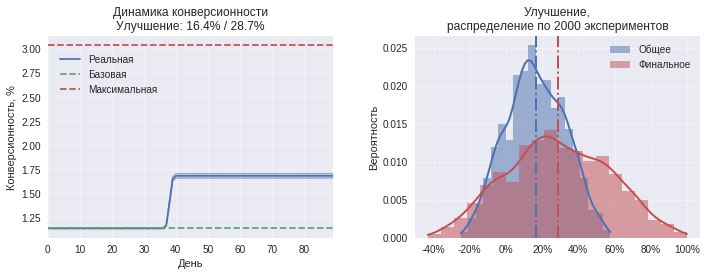

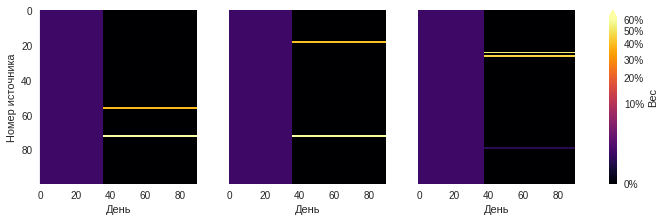

In [9]:
#@title Наивная стратегия
M=38 #@param {type:"integer"}
run_simulation(lambda: NaiveStrategy(M)) 

        Общее улучшение: 34.0%
    Финальное улучшение: 49.6%
    Общая эффективность: 59.0%
Финальная эффективность: 68.7%


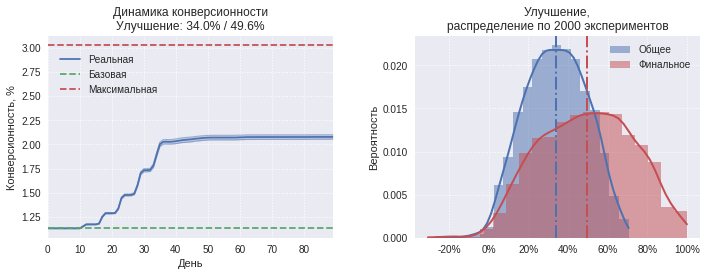

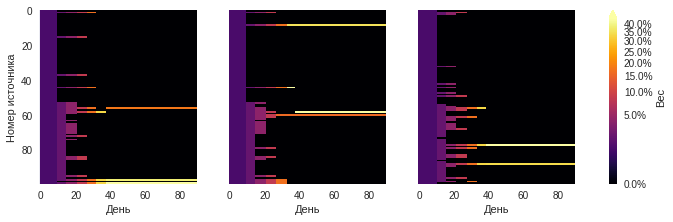

In [10]:
#@title SuccessiveHalving
M=11 #@param {type:"integer"}
run_simulation(lambda: HalvingStrategy(M)) 

        Общее улучшение: 38.1%
    Финальное улучшение: 54.5%
    Общая эффективность: 61.5%
Финальная эффективность: 71.8%


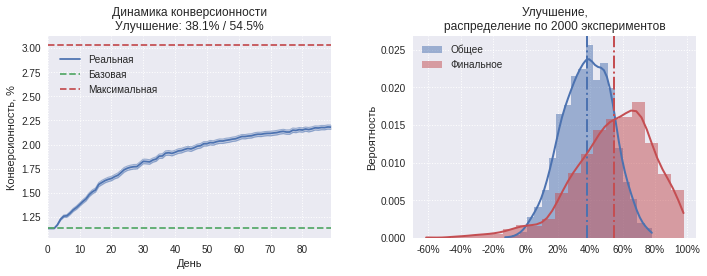

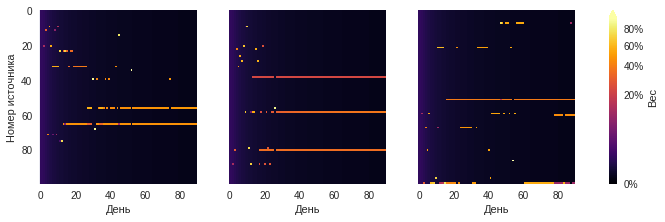

In [5]:
#@title ϵ-decreasing
ϵ=3.5 #@param {type:"number"}
run_simulation(lambda: EpsilonDecreasingStrategy(3.5)) 

        Общее улучшение: 40.3%
    Финальное улучшение: 56.1%
    Общая эффективность: 62.9%
Финальная эффективность: 72.7%


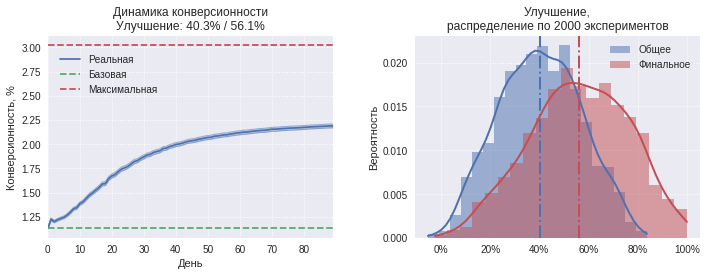

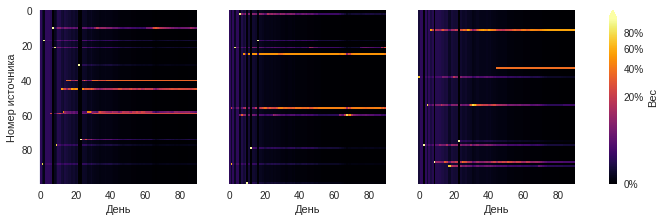

In [6]:
#@title Softmax
τ0=11 #@param {type:"number"}
run_simulation(lambda: SoftmaxStrategy(τ0)) 

        Общее улучшение: 39.2%
    Финальное улучшение: 55.0%
    Общая эффективность: 62.1%
Финальная эффективность: 71.8%


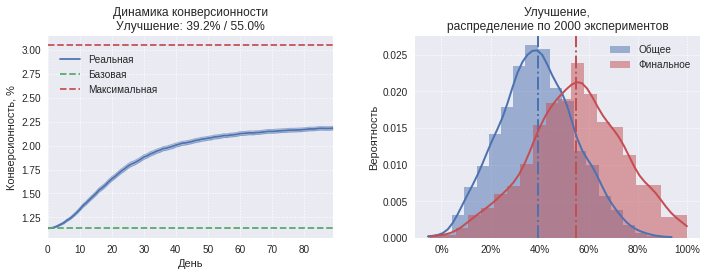

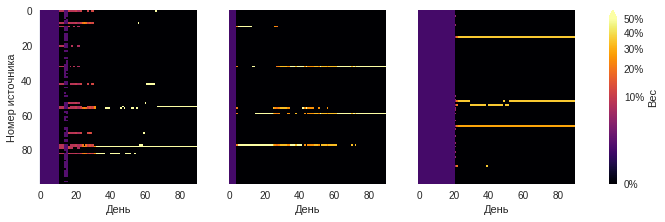

In [7]:
#@title Credible bounds racing
interval_quantile=0.34 #@param {type:"number"}
run_simulation(lambda: CBRacingStrategy(a,b, interval_quantile)) 



        Общее улучшение: 39.4%
    Финальное улучшение: 57.2%
    Общая эффективность: 62.5%
Финальная эффективность: 73.6%


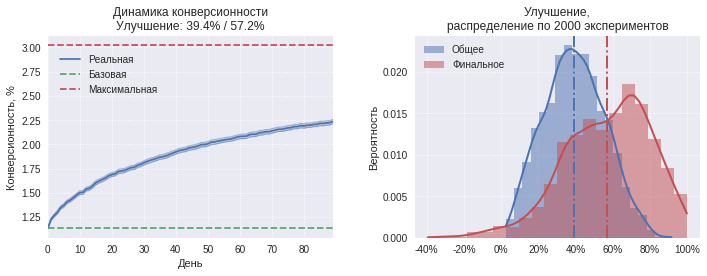

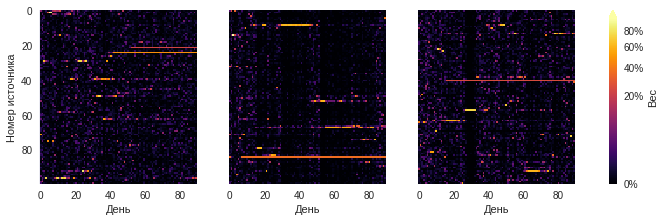

In [8]:
#@title Probability mathcing
ρ=7 #@param {type:"number"}
γ=1 #@param {type:"number"}
n_samples=512 #@param {type:"integer"}
run_simulation(lambda: ProbMatchingStrategy(a, b, sample_size=n_samples, power=ρ, sampler='numpy')) 



In [9]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

